In [1]:
import torch
from torch import nn

import torch.functional as F

from PIL import Image
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import requests
import io

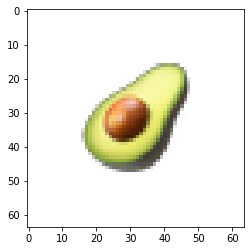

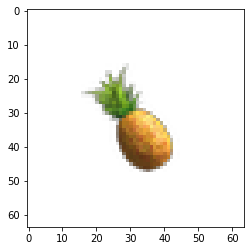

In [2]:
def load_image(url, max_size=32, padding=16):
    r = requests.get(url)
    img = Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), Image.ANTIALIAS)
    img = np.float32(img)/255.0
    img = np.pad(img,((padding,padding),(padding,padding),(0,0)))
    
    img[..., :3] *= img[..., 3:]
    
    img = torch.Tensor(img).float().cuda()
    img = img.transpose(0,2)

    return img


def load_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    url = 'https://raw.githubusercontent.com/iamcal/emoji-data/master/img-apple-64/%s.png' % code
    return load_image(url)


avocado = load_emoji("🥑")
pineapple = load_emoji("🍍")

plt.imshow(avocado.transpose(0,2).cpu())
plt.show()
plt.imshow(pineapple.transpose(0,2).cpu())
plt.show()

img_size = 64

In [4]:
class Automata(nn.Module):

    def __init__(self, grid_size, n_channels):

        super(Automata, self).__init__()

        self.n_channels = n_channels
        self.grid_size = grid_size

        self.filters = torch.Tensor([[[[-1, 0, 1],
                                       [-2, 0, 2],
                                       [-1, 0, 1]
                                       ]],
                                     [[[-1, -2, -1],
                                       [0, 0, 0],
                                       [1, 2, 1]
                                       ]],
                                     [[[0, 0, 0],
                                       [0, 1, 0],
                                       [0, 0, 0]
                                       ]]]).cuda()

        self.mapper = nn.Sequential(
            nn.Linear(3*n_channels, 128),
            nn.ReLU(),
            nn.Linear(128, n_channels),
            nn.Tanh()
        )

        self.mapper[2].weight.data.fill_(0)
        self.mapper[2].bias.data.fill_(0)

    def perception(self, x):

        # reshape for same convolution across channels
        x = x.reshape(-1, 1, self.grid_size[0], self.grid_size[1])

        # toroidal padding
        conved = nn.functional.pad(x, (1, 1, 1, 1), mode="reflect")

        conved = nn.functional.conv2d(conved, model.filters)

        # reshape for perception computations
        conved = conved.view(self.batch_size, 3*self.n_channels, -1)
        conved = conved.transpose(1, 2)

        conved = self.mapper(conved)

        conved = conved.transpose(1, 2)
        # (batch_size, channels, total_cells)

        conved = conved.view(self.batch_size, self.n_channels, *self.grid_size)

        can_update = torch.rand_like(conved) < 0.75

        return conved*can_update

    def forward(self, x, iterations, keep_history=False):

        if keep_history:

            model.history = torch.zeros(iterations, *x.shape)

        model.batch_size = x.shape[0]

        for i in range(iterations):

            x = x + self.perception(x)

            is_alive = nn.functional.max_pool2d(
                x[:, 3], (3, 3), stride=1, padding=1) > 1/8

            is_alive = is_alive.unsqueeze(1)

            x = x*is_alive

            x[:, :4].clamp_(0, 1)

            if keep_history:

                model.history[i] = x

        return x

In [5]:
n_channels = 16
n_epochs = 5000
lr = 0.001
pool_size = 1024
batch_size = 8

image_1 = avocado
image_2 = pineapple

model = Automata((64, 64), n_channels).cuda()

# initialize pool with seeds
seed = torch.zeros(n_channels,img_size,img_size).cuda()
seed[3:,32,32] = 1

pool_initials = seed[None, :].repeat(pool_size,1,1,1)
pool_targets = image_1[None,:].repeat(pool_size,1,1,1)
pool_target_ids = torch.ones(pool_size)

# 0 for seed, 1 for image_1, 2 for image_2

losses = []

criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(n_epochs):
    
#     iterations = random.randint(64,96)
    iterations = 64

    pool_indices = torch.Tensor(random.sample(range(pool_size),batch_size)).long()
        
    initial_states = pool_initials[pool_indices]
    targets = pool_targets[pool_indices]
    target_ids = pool_target_ids[pool_indices]

    out = model(initial_states,iterations)
    
    phenotypes = out[:,:4].squeeze()

    optimizer.zero_grad()

    loss = criterion(phenotypes, targets)
    
    per_sample_loss = loss.mean((1,2,3))
    total_loss = per_sample_loss.mean()

    total_loss.backward()
    optimizer.step()
    
    max_loss_idx = per_sample_loss.topk(4).indices
    
    # switch half of the initial states
    swap_indices = random.sample(range(batch_size),4)
    
    for swap_idx in swap_indices:
        pool_idx = pool_indices[swap_idx]
        target_id = int(pool_target_ids[pool_idx])
        
        # if output is the first image,
        # switch the target to the second
        if target_id == 1:
            pool_targets[pool_idx] = image_2
            pool_target_ids[pool_idx] = 2

        # if output is the second image,
        # make it stay there
        if target_id == 2:
            pool_targets[pool_idx] = image_2
            pool_target_ids[pool_idx] = 2
    
    replacements = out.detach()
    replacements[max_loss_idx] = seed.clone()
    
    pool_targets[pool_indices[max_loss_idx]] = image_1
    pool_target_ids[pool_indices[max_loss_idx]] = 1

    pool_initials[pool_indices] = replacements

    if i % 10 == 0:
    
        print(i, np.log10(float(total_loss.cpu().detach())))
        
    losses.append(float(total_loss))

0 -1.0723602581784166
10 -1.665369992607259
20 -2.060008374789109
30 -1.7385687341471827
40 -1.6552502267510156
50 -1.3545946840655665
60 -1.6212083964475448
70 -1.7797648953022254
80 -1.7967668386907616
90 -1.5857844060939508
100 -1.6656331320473525
110 -1.6949541484625108
120 -1.5455822127047967
130 -1.7726289472124785
140 -2.2357456958354858
150 -1.7228921367452485
160 -1.6582572130340263
170 -1.6105767943297615
180 -1.6233746014150334
190 -1.7471921328385724
200 -1.5187662937834503
210 -1.7931942565633237
220 -1.4750346825234522
230 -1.7545010315210918
240 -1.7556699906742204
250 -1.7633639094873166
260 -1.7825017426503216
270 -1.8898913882382982
280 -1.865947685032459
290 -1.3845630870659593
300 -1.6574093893668231
310 -1.6802562809431523
320 -1.6646402754984835
330 -1.5340189098165626
340 -1.5797444021758256
350 -1.6769731806832913
360 -1.7500399367589954
370 -1.623180793438313
380 -1.6081061925729214
390 -1.8612514120313721
400 -1.4414393205159257
410 -1.6331050440993395
420 -1.

3360 -1.9861952030073056
3370 -1.9490383033710728
3380 -2.0790694589386414
3390 -1.9373086328682523
3400 -2.2792132286142204
3410 -2.3257687494586223
3420 -2.010065265394891
3430 -1.823457571545572
3440 -2.321792969628242
3450 -1.9722664662199376
3460 -2.5199949398975514
3470 -1.9801936840415935
3480 -1.9659275464143706
3490 -2.0188399263681482
3500 -2.115615087852247
3510 -2.7032508215536653
3520 -2.1151953702978767
3530 -2.0425761378294567
3540 -2.220802501729495
3550 -2.263679050118431
3560 -2.139079571827616
3570 -2.02033754974613
3580 -2.018771249486056
3590 -2.052746160419345
3600 -2.144796205879256
3610 -1.8056657172965578
3620 -1.9203531198657682
3630 -1.987352437200998
3640 -1.9791278100785519
3650 -2.664096674589616
3660 -2.2171125904405082
3670 -2.1090213591119324
3680 -2.023724432158812
3690 -2.035097569901619
3700 -2.2395246374144024
3710 -1.9015059658398406
3720 -1.933756616558452
3730 -2.3361422121312097
3740 -2.3980626097874502
3750 -2.273642921146155
3760 -1.9337913081

In [1]:
plt.plot(np.log10(losses))

NameError: name 'plt' is not defined

In [11]:
pool_target_ids[:100]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

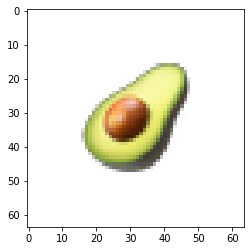

In [14]:
plt.imshow(pool_targets[0,:4].transpose(0,2).cpu())

In [10]:
out = model(seed[None,:],512,keep_history=True).squeeze()

In [11]:
video = model.history.cpu().detach()
video = video[:,0,:4]
video = video.transpose(1,3)

In [12]:
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close()

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init,  frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())